#**CHAPTER 4. MOMENTUM AND MARKET RISK GATE**
---

##0.REFERENCE

https://chatgpt.com/share/698dcaef-a8f0-8012-9b8f-d7da7cbd0ac6

##1.CONTEXT

**Introduction — Strategy 4: Momentum + Market Risk Gate**

Momentum strategies occupy an awkward position in quantitative finance. They are among the most empirically persistent cross-asset phenomena, yet they are also among the most regime-fragile policies a professional desk can hold with confidence. The reason is not mysterious when framed mechanism-first. Momentum is not a timeless “edge.” It is an interaction between slow capital, behavioral under-reaction, benchmarked flows, and the market’s constraint set. When constraints are slack and liquidity is abundant, trends can persist because the marginal buyer and seller respond with delay. When constraints bind—through volatility expansion, correlation compression, funding stress, or forced de-risking—trend following can invert abruptly, not because “momentum stopped working,” but because the environment shifted from gradual price discovery to synchronized balance-sheet management. In that second environment, yesterday’s winners are often the assets most exposed to liquidation and crowding, and the very act of holding them becomes a mechanism for absorbing systemic deleveraging. That is the structural intuition behind this laboratory.

This notebook implements **Strategy 4 — Momentum + Market Risk Gate** as a governed experimental environment. The strategy is intentionally simple at the policy layer: compute a cross-sectional momentum ranking, select a top subset, and allocate equal weight. The sophistication—and the pedagogical value—lives in the environment and its state variables. The policy is not meant to be clever. It is meant to be bounded and readable so that the reader can attribute outcomes to mechanisms rather than to over-parameterized decision rules. The Market Risk Gate is the central mechanism: a composite state that determines whether momentum exposure is feasible under the prevailing risk geometry. When the gate is **ON**, momentum exposure is allowed; when it is **OFF**, the agent is forced to neutralize. This conditional activation is the core idea: the policy is not “always trend.” It is “trend only when the market’s risk surface indicates that trend is structurally tradable.”

The economic context begins with the observation that momentum is a **flow-compatible** strategy. It benefits from persistence in demand imbalances, slow information diffusion, and institutional frictions that prevent immediate arbitrage. In calm conditions, dispersion across assets can produce stable cross-sectional ranking, and portfolio turnover can remain within feasible limits. However, momentum becomes fragile precisely when the market’s correlation structure compresses and volatility expands. Correlation compression is not a statistical curiosity; it is the market’s risk geometry reconfiguring under common shocks and forced selling. In a compressed-correlation regime, diversification fails, cross-sectional rank signals become less informative, and a long-only momentum sleeve can become an implicit leveraged bet on the dominant market factor. Even if the signal is computed correctly, the portfolio’s realized behavior changes because the covariance surface has changed.

This is where the notebook’s “surface” language matters. The laboratory constructs and exposes two primary surfaces that determine feasibility. The first is the **risk gate surface**: a regime-indexed mapping from observable state variables—rolling market volatility, rolling correlation compression proxies, and rolling drawdown state—into a scalar risk metric. This metric is not an oracle; it is a cost-of-risk summary. It behaves as a surface because it varies smoothly (or abruptly, under stress) with regime, and because it can be “traded” in the sense that it prices the feasibility of holding exposure. The second surface is the **execution surface**: a mapping from desired turnover and liquidity conditions into realized costs, expressed through proportional transaction costs and quadratic impact. In this notebook, liquidity stress is not a footnote; it is state-dependent and worsens in crisis regimes. That is mechanism-first realism: the cost of changing inventory is not constant; it steepens precisely when the agent wants to change inventory most.

The agentic structure is therefore straightforward but complete. The agent observes the state at each step: the momentum signal vector, its dispersion across the cross-section, the risk gate components, and its own portfolio history (for volatility targeting and drawdown awareness). It then makes a bounded decision: whether the gate permits risk; if permitted, which assets are in the top momentum subset; what the target weights are under volatility targeting and leverage caps; and whether survival constraints (drawdown stops) require de-risking regardless of signal. The environment then applies the transition: it computes turnover, prices the transition using the execution surface (proportional plus quadratic impact), applies regime-consistent returns (including stress-dependent behavior), and updates equity. The agent does not “predict.” It responds to state and pays for transitions. This is the correct framing for professional trading: the realized path is determined as much by costs, constraints, and regime transitions as by the nominal signal.

The notebook demonstrates several structural lessons that are easy to miss in conventional backtests. First, cross-sectional momentum requires **dispersion** to be meaningful. If the distribution of momentum scores collapses—because correlations rise or because the market is dominated by one factor—the ranking becomes unstable and small estimation noise can cause large turnover. This is why the strategy includes a dispersion filter: it is not a performance hack; it is a mechanism guardrail. Second, the risk gate is not merely a volatility filter. Volatility alone can be high during persistent trends, and it can be low during complacent pre-crisis phases. The gate is therefore constructed as a composite: volatility (risk intensity), correlation compression (risk geometry), and drawdown state (constraint bindingness). In a mechanism-first interpretation, these variables proxy for whether the market is pricing risk through gradual repricing or through constraint-driven liquidation. Third, execution dominates theory. Even if the portfolio has positive expected signal contribution, the combination of high turnover and liquidity-worsened impact can erase the edge. This is not an implementation detail; it is the difference between a research-grade idea and a tradable policy.

The notebook also embeds governance because governance is not optional when strategies are fragile. Every run produces structured artifacts—metrics, diagnostics, stress results, sensitivity grids, Monte Carlo envelopes, fragility scoring, deployment classification, reproducibility reports, and tamper-evident hash registries—each labeled **verification_status = "Not verified"**. This is not bureaucratic decoration. It is a research discipline: it forces the reader to separate facts from assumptions, to record open questions, and to avoid the common failure mode of treating a single backtest path as proof. The risk evaluation layer is designed to answer an institutional question: not “did it make money here,” but “how does it fail, under what structural shifts, and what controls are minimally required to keep the failure from becoming existential?”

Because the environment is synthetic, the notebook can treat regimes as explicit objects rather than as hidden statistical states. It constructs calm, trend, choppy, and crisis regimes with different drift/volatility levels, different correlation compression parameters, and different liquidity stress multipliers. That allows controlled experiments: one can increase correlation compression without changing drift, or increase liquidity stress without changing signal quality, and observe the resulting change in feasibility. In real markets, these drivers often co-move, which makes causality hard to isolate. The synthetic laboratory is therefore not an attempt to “simulate reality”; it is an attempt to expose the causal levers of tradability.

The guiding philosophy is to treat the market as a mechanism that produces constraints, not merely returns. Momentum can look strong in a frictionless model precisely because the model ignores the surfaces that matter: correlation geometry and execution. This notebook reintroduces those surfaces and then asks the reader to study the strategy as an interaction between state, constraints, and policy. The Market Risk Gate is the conceptual hinge. It is a recognition that the same signal can mean different things in different geometries, and that a bounded policy must condition on feasibility if it wants to survive. The aim is not to build a production trading system. It is to build professional intuition: to understand why momentum is sometimes a stable harvesting of persistence and sometimes a structurally crowded exposure that collapses when the market’s constraint set binds.

Finally, the notebook is designed to be iterated, not admired. The proper use is experimental: change the lookback horizon to study horizon dependence; vary the gate threshold to study sensitivity; stress the gate via misclassification to understand how state estimation errors propagate; stress the strategy via momentum crashes to observe fragility; and compare performance diagnostics not as trophies but as evidence of mechanism alignment. The artifacts and dashboards are there to support that experimental workflow. They convert the notebook into a reproducible laboratory where the main outcome is not a number, but a structural understanding of how conditional momentum behaves when markets stop being smooth and start being constrained.


##2.LIBRARIES AND ENVIRONMENT



**Objective**
Build an institutional-grade research pipeline for a Momentum strategy that is conditionally deployed only when a Market Risk Gate indicates a supportive regime. The lab is synthetic-first and mechanism-oriented: it models regime structure, correlation compression, liquidity stress, transaction costs, slippage/impact, and governance stage gates.

Synthetic Disclaimer  
All prices, returns, regimes, liquidity, and shocks are synthetically generated for mechanism isolation and stress testing only. This notebook does NOT claim real-world profitability.

10 Trade-Logic Elements (implemented)  
1) Universe definition: 20 synthetic equities with factor structure + idiosyncratic risk.  
2) Primary signal: cross-sectional momentum over a fixed lookback (default 90 days).  
3) Secondary filter(s): Market Risk Gate built from (i) rolling market volatility, (ii) rolling average correlation, (iii) rolling market drawdown.  
4) Entry rule: when Gate=ON and signal dispersion exceeds threshold, long top quantile by momentum.  
5) Exit rule: Gate=OFF OR dispersion collapses OR asset leaves top set at rebalance.  
6) Position direction: long-only (conditional activation).  
7) Holding horizon: daily evaluation; rebalanced when Gate=ON.  
8) Portfolio construction: equal-weight top set; scaled by volatility targeting subject to leverage cap.  
9) Risk controls: volatility target, leverage cap, drawdown stop (de-risk), turnover-aware costs, liquidity-dependent slippage/impact.  
10) Governance gates: signal validity, execution feasibility (turnover/cost), stress survival, fragility scoring → risk tier + deployment classification.

Notebook Structure  
Exactly 10 cells: governance setup → synthetic market → signals → trading engine → metrics/diagnostics → stress suite → governance/risk engine → visualization dashboard → audit bundle + Monte Carlo + sensitivity + hashing + ZIP.


In [1]:
# CELL 2 — GOVERNANCE SETUP (Deterministic, Audit-Ready)

import math
import random
import statistics
import json
import os
import hashlib
import datetime
import sys
import platform
import zipfile

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Deterministic CONFIG (single source of truth)
# -----------------------------
CONFIG = {
    "seed": 404,
    "n_assets": 20,
    "n_days": 150,  # ~5 years of trading days
    "regime_block": 210,  # deterministic regime rotation cadence
    "momentum_lookback": 90,
    "risk_lookback": 60,
    "rebalance_frequency": 1,  # daily evaluation
    "top_fraction": 0.20,  # top quintile
    "dispersion_threshold": 0.020,  # dispersion in momentum scores
    "risk_threshold": 1.00,  # gate threshold in standardized risk units
    "vol_target_annual": 0.15,
    "vol_target_lookback": 60,
    "leverage_cap": 1.20,
    "drawdown_stop": -0.18,  # de-risk when dd below threshold
    "tcost_bps": 5.0,  # baseline proportional cost per 1.0 turnover (bps)
    "impact_k_bps": 8.0,  # quadratic impact coefficient (bps)
    "liquidity_stress_multiplier_max": 4.0,
    "stress_tests_generic": ["vol_spike", "corr_compress", "crash_shift", "liquidity_shock"],
    "stress_tests_strategy": ["momentum_crash", "gate_misclassification"],
    "sensitivity": {
        "momentum_lookback": [60, 90, 120],
        "risk_threshold": [0.80, 1.00, 1.20, 1.40],
        "top_fraction": [0.10, 0.20, 0.30]
    },
    "monte_carlo_runs": 250,  # >= 200 required
    "monte_carlo_noise_scale": 0.35,  # residual perturbation intensity
    "integrity_hash_alg": "sha256"
}

# -----------------------------
# Determinism
# -----------------------------
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

UTC_NOW = datetime.datetime.now(datetime.timezone.utc).isoformat()

# -----------------------------
# Directories
# -----------------------------
DELIVERABLES_DIR = "deliverables"
if not os.path.exists(DELIVERABLES_DIR):
    os.makedirs(DELIVERABLES_DIR)

# -----------------------------
# Helpers (pure-Python governance utilities)
# -----------------------------
def _stable_json_dumps(obj):
    return json.dumps(obj, sort_keys=True, separators=(",", ":"))

def sha256_bytes(b):
    return hashlib.sha256(b).hexdigest()

def sha256_file(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            chunk = f.read(1024 * 1024)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def write_artifact(path, analysis_dict=None, outputs_dict=None, facts=None, assumptions=None, open_items=None):
    payload = {
        "verification_status": "Not verified",
        "facts_provided": facts or {},
        "assumptions": assumptions or {},
        "open_items": open_items or [],
        "analysis": analysis_dict or {},
        "outputs": outputs_dict or {}
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, sort_keys=True)

def env_fingerprint():
    info = {
        "python_version": sys.version.replace("\n", " "),
        "platform": platform.platform(),
        "implementation": platform.python_implementation(),
        "executable": sys.executable,
        "numpy_version": np.__version__,
        "matplotlib_version": plt.matplotlib.__version__
    }
    return info

CONFIG_HASH = sha256_bytes(_stable_json_dumps(CONFIG).encode("utf-8"))
RUN_ID = sha256_bytes((UTC_NOW + "|" + CONFIG_HASH).encode("utf-8"))[:16]

# -----------------------------
# Root Artifacts (run_manifest, prompts_log, risk_log)
# -----------------------------
run_manifest = {
    "run_id": RUN_ID,
    "timestamp_utc": UTC_NOW,
    "config_hash": CONFIG_HASH,
    "config": CONFIG,
    "environment_fingerprint": env_fingerprint(),
    "determinism": {
        "python_random_seed": CONFIG["seed"],
        "numpy_random_seed": CONFIG["seed"]
    },
    "integrity": {
        "hash_algorithm": CONFIG["integrity_hash_alg"],
        "notebook_cells": 10
    },
    "verification_status": "Not verified"
}
with open("run_manifest.json", "w", encoding="utf-8") as f:
    json.dump(run_manifest, f, indent=2, sort_keys=True)

# prompts_log.jsonl (append-only)
prompt_event = {
    "timestamp_utc": UTC_NOW,
    "run_id": RUN_ID,
    "event_type": "run_start",
    "content_redacted": True,
    "content_hash": sha256_bytes(("Strategy4|Momentum+RiskGate|" + CONFIG_HASH).encode("utf-8")),
    "notes": "Synthetic-only governed run. No external data. No confidential inputs."
}
with open("prompts_log.jsonl", "a", encoding="utf-8") as f:
    f.write(json.dumps(prompt_event, sort_keys=True) + "\n")

# risk_log.json (production-grade: explicit risks & controls)
risk_log = {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {
        "synthetic_data": True,
        "no_external_validation": True
    },
    "open_items": [
        "Human review required before any real deployment consideration.",
        "External benchmark comparisons intentionally excluded in synthetic-only lab."
    ],
    "analysis": {
        "capability_risks": [
            {"risk": "Overfitting via parameter selection", "controls": ["Sensitivity grid", "Monte Carlo envelope", "Stage gate thresholds"]},
            {"risk": "Regime leakage / gate tautology", "controls": ["Explicit gate definition", "Gate misclassification stress test", "Ablation via gate-off states"]},
            {"risk": "Execution illusion (ignoring costs)", "controls": ["Turnover tracking", "Liquidity-dependent costs", "Quadratic impact", "Execution audit artifact"]},
            {"risk": "False confidence from synthetic structure", "controls": ["Fragility scoring", "Stress suite", "Not verified labeling", "No profitability claims"]}
        ],
        "minimum_controls": [
            "Deterministic seeds + config hashing",
            "Artifact hash registry + master bundle hash",
            "Stress tests rerun full backtest",
            "Monte Carlo robustness envelope",
            "Review checklist + deployment classification"
        ]
    },
    "outputs": {
        "risk_owner": "Human researcher",
        "status": "Research-only until verified"
    }
}
with open("risk_log.json", "w", encoding="utf-8") as f:
    json.dump(risk_log, f, indent=2, sort_keys=True)


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

Cell 3

Cell 3 constructs the synthetic market environment in which Strategy 4 is tested. The key design choice is that the market is not generated as a single stationary return process. Instead, it is built as a sequence of regimes—calm, trend, choppy, and crisis—each with distinct drift, volatility, correlation compression, and liquidity stress parameters. This is essential for a momentum laboratory because the defining fragility of momentum is regime dependence. In calm and trend states, persistence can exist without destabilizing risk geometry. In choppy and crisis states, persistence may disappear and liquidation dynamics dominate. By making regimes explicit objects, the notebook provides a clean mapping from state to tradability.

Mechanism-first, the economic meaning of the regime parameters matters. Drift is not simply a return assumption; it proxies for systematic demand imbalances that can sustain trends. Volatility is not merely noise; it is a proxy for constraint bindingness, margin sensitivity, and risk-budget tightening. Correlation compression is a proxy for risk geometry collapse: the market’s dimensionality shrinks as assets co-move under common shocks, which is precisely when cross-sectional ranking signals become unstable. Liquidity stress is modeled as a multiplier that steepens the execution surface during crisis regimes, reflecting that trades become more expensive when balance sheets are fragile.

The cell also specifies a factor structure: asset returns are generated as a combination of a market component (scaled by asset betas) and an idiosyncratic component, with an additional shared shock term used to control cross-asset correlation. This matters because a cross-sectional momentum portfolio can become unintentionally dominated by market beta when correlations rise. The factor structure allows the later attribution analysis to separate the beta component from residual performance, reinforcing the idea that “momentum profits” in stress periods often reduce to factor exposure rather than genuine cross-sectional selection skill.

Finally, the output of Cell 3 is not only price paths but also the latent regime state and liquidity multipliers. These are the primitives that later cells treat as tradable surfaces: regimes change the risk surface, and liquidity multipliers change the execution surface. The learning objective is to train the reader to view the market as a generator of constraints and geometries, not merely a generator of returns. This creates the controlled experimental substrate on which the Market Risk Gate can be interpreted as a feasibility mechanism rather than a predictive filter.

###3.2.CODE AND IMPLEMENTATION

In [2]:
# CELL 3 — SYNTHETIC MARKET GENERATOR (≥4 regimes, factor-aware, liquidity-aware)

N = CONFIG["n_days"]
M = CONFIG["n_assets"]
REGIME_BLOCK = CONFIG["regime_block"]

# Regimes: deterministic schedule (0..3 repeating)
# 0: Calm (low vol, moderate drift), 1: Trend (higher drift), 2: Choppy (mean-reverting / low drift, moderate vol),
# 3: Crisis (negative drift, high vol, high corr, liquidity stress)
REGIMES = {
    0: {"name": "calm",   "mu_mkt": 0.00035, "sigma_mkt": 0.010, "corr": 0.25, "liq_stress": 0.8},
    1: {"name": "trend",  "mu_mkt": 0.00070, "sigma_mkt": 0.012, "corr": 0.30, "liq_stress": 0.9},
    2: {"name": "choppy", "mu_mkt": 0.00005, "sigma_mkt": 0.016, "corr": 0.45, "liq_stress": 1.2},
    3: {"name": "crisis", "mu_mkt": -0.00100,"sigma_mkt": 0.032, "corr": 0.80, "liq_stress": 2.6}
}

# Factor model: r_i,t = beta_i * r_mkt,t + eps_i,t
# betas are fixed cross-sectionally; eps is idiosyncratic with regime-scaled variance.
betas = [max(0.4, min(1.6, random.gauss(1.0, 0.25))) for _ in range(M)]
idio_scales = [max(0.5, min(1.8, random.gauss(1.0, 0.30))) for _ in range(M)]

# Storage
prices = [[100.0] for _ in range(M)]
asset_rets = [[] for _ in range(M)]
mkt_ret = []
regime_id = []
regime_name = []
liq_multiplier = []  # execution stress proxy

# Deterministic crisis micro-shocks (rare tail events inside crisis blocks)
def crisis_tail_shock(t_index, base_sigma):
    # deterministic pseudo-tail schedule: every 21st day inside a crisis block
    if (t_index % 21) == 0:
        return np.random.normal(-4.0 * base_sigma, 1.5 * base_sigma)
    return 0.0

for t in range(1, N):
    r_id = (t // REGIME_BLOCK) % 4
    spec = REGIMES[r_id]
    regime_id.append(r_id)
    regime_name.append(spec["name"])

    # Market return
    base = np.random.normal(spec["mu_mkt"], spec["sigma_mkt"])
    tail = crisis_tail_shock(t, spec["sigma_mkt"]) if r_id == 3 else 0.0
    r_m = base + tail
    mkt_ret.append(r_m)

    # Liquidity multiplier (bounded, deterministic given seed)
    # Higher in stress; slight stochasticity for realism, clipped.
    lm = spec["liq_stress"] * max(0.6, min(CONFIG["liquidity_stress_multiplier_max"], np.random.normal(1.0, 0.12)))
    liq_multiplier.append(lm)

    # Asset returns (one-factor correlation controlled via corr parameter)
    # Implement via mixing: eps partially shared to create correlation compression beyond one-factor.
    corr = spec["corr"]
    shared_eps = np.random.normal(0.0, spec["sigma_mkt"])
    for i in range(M):
        eps = np.random.normal(0.0, spec["sigma_mkt"] * 0.9 * idio_scales[i])
        # correlation compression component
        eps_eff = corr * shared_eps + (1.0 - corr) * eps
        r_i = betas[i] * r_m + eps_eff
        asset_rets[i].append(r_i)
        prices[i].append(prices[i][-1] * (1.0 + r_i))

# Market index price
mkt_price = [100.0]
for t in range(1, N):
    mkt_price.append(mkt_price[-1] * (1.0 + mkt_ret[t-1]))

# Update manifest with structural info
write_artifact(
    os.path.join(DELIVERABLES_DIR, "diagnostics.json"),
    analysis_dict={
        "market_generator": {
            "n_assets": M,
            "n_days": N,
            "regime_block": REGIME_BLOCK,
            "regimes": REGIMES,
            "beta_summary": {"min": min(betas), "max": max(betas), "mean": statistics.mean(betas)},
            "idio_scale_summary": {"min": min(idio_scales), "max": max(idio_scales), "mean": statistics.mean(idio_scales)}
        }
    },
    outputs_dict={
        "mkt_return_sample": mkt_ret[:5],
        "liq_multiplier_sample": liq_multiplier[:5],
        "regime_name_sample": regime_name[:12]
    }
)


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

Cell 4

Cell 4 computes the strategy’s primary signal and the first layer of diagnostics. The primary signal is cross-sectional momentum measured over a fixed lookback window: for each asset, the signal is the cumulative return over the lookback horizon. This is intentionally minimal. In a mechanism-first notebook, the signal should be transparent so that failure modes can be attributed to the environment rather than to hidden feature engineering. Momentum here is treated as a ranking device: it produces a vector of scores whose ordering determines the portfolio’s candidate winners.

The cell then computes signal dispersion and information coefficient (IC). Dispersion is a structural diagnostic: it measures whether the signal vector contains meaningful cross-sectional separation. When dispersion collapses, ranking becomes unstable; tiny perturbations can swap membership in the top set. That instability is not harmless. It translates into turnover, and turnover translates into execution costs that can dominate returns. The dispersion series therefore anticipates a core failure mode of momentum: not that the signal is wrong, but that it is too weakly differentiated to support repeated portfolio transitions under costs.

The information coefficient is computed as a cross-sectional Spearman correlation between today’s momentum scores and next-day returns. This is not presented as a forecasting claim. It is a skill diagnostic that quantifies whether the signal has any monotonic relationship with subsequent realized outcomes in the synthetic environment. Using Spearman rather than Pearson emphasizes robustness to outliers and focuses on rank ordering, which is the economic object that a cross-sectional momentum allocator actually uses. Rolling IC is included to expose regime dependence: even when average IC is positive, it may be concentrated in certain regimes and may degrade sharply during crisis transitions.

Structurally, Cell 4 creates the “signal surface” of the laboratory: a time-indexed matrix of momentum scores. Later, the bounded policy consumes this surface under constraints. The learning objective is to show that signal analysis is not just about average strength; it is about dispersion, stability, and regime-conditioned behavior. In institutional research, the question is not “does momentum work on average,” but “when does the signal become economically tradable given the execution surface and the risk gate surface.” Cell 4 provides the measurement layer required to answer that question, before any trading decisions are made.


###4.2.CODE AND IMPLEMENTATION

In [3]:
# CELL 4 — SIGNAL COMPUTATION (Momentum, dispersion, IC + rolling IC)

LB = CONFIG["momentum_lookback"]
RLB = CONFIG["risk_lookback"]

def safe_mean(x):
    return statistics.mean(x) if x else 0.0

def safe_pstdev(x):
    return statistics.pstdev(x) if (x and len(x) > 1) else 0.0

def rankdata(values):
    # average ranks for ties
    idx = list(range(len(values)))
    idx.sort(key=lambda i: values[i])
    ranks = [0.0] * len(values)
    i = 0
    while i < len(values):
        j = i
        while j + 1 < len(values) and values[idx[j+1]] == values[idx[i]]:
            j += 1
        avg_rank = 0.5 * (i + j) + 1.0  # 1-based
        for k in range(i, j+1):
            ranks[idx[k]] = avg_rank
        i = j + 1
    return ranks

def pearson_corr(a, b):
    if len(a) != len(b) or len(a) < 2:
        return 0.0
    ma = statistics.mean(a)
    mb = statistics.mean(b)
    cov = 0.0
    va = 0.0
    vb = 0.0
    for i in range(len(a)):
        da = a[i] - ma
        db = b[i] - mb
        cov += da * db
        va += da * da
        vb += db * db
    if va <= 0.0 or vb <= 0.0:
        return 0.0
    return cov / math.sqrt(va * vb)

def spearman_corr(x, y):
    rx = rankdata(x)
    ry = rankdata(y)
    return pearson_corr(rx, ry)

# Momentum signals for days t where t-LB is valid and next-day returns exist
signals = []          # list over time: length T, each is list of length M
dispersion = []       # stdev of cross-sectional signals
ic_series = []        # IC between signal and next-day returns (cross-sectional)
ic_roll_60 = []       # rolling IC mean (60 obs)

# Precompute next-day returns arrays by time for cross-section
# asset_rets[i][t-1] is return from day t-1 -> t in price index, aligned with prices list.
# We'll define signal time index s_t corresponds to calendar day t in [LB..N-2] so next return is asset_rets[i][t].
for t in range(LB, N-1):
    # momentum = price(t) / price(t-LB) - 1
    mom = []
    for i in range(M):
        past = prices[i][t - LB]
        now = prices[i][t]
        mom.append((now / past) - 1.0)
    signals.append(mom)
    dispersion.append(safe_pstdev(mom))

    # IC with next-day returns (t -> t+1): that return is asset_rets[i][t] because asset_rets is 0..N-2 indexing
    if t < N - 1:
        next_rets = [asset_rets[i][t] for i in range(M)]
        ic = spearman_corr(mom, next_rets)
    else:
        ic = 0.0
    ic_series.append(ic)

    # rolling IC mean (window 60 over ic_series index)
    w = 60
    if len(ic_series) >= w:
        ic_roll_60.append(statistics.mean(ic_series[-w:]))
    else:
        ic_roll_60.append(statistics.mean(ic_series))

# Persist signal matrix (sample + metadata)
write_artifact(
    os.path.join(DELIVERABLES_DIR, "signal_matrix.json"),
    analysis_dict={
        "signal_definition": {
            "type": "cross_sectional_momentum",
            "lookback_days": LB,
            "ic_definition": "Spearman(signal_t, next_day_return_t+1) cross-sectionally",
            "rolling_ic_window": 60
        },
        "signal_diagnostics": {
            "dispersion_mean": safe_mean(dispersion),
            "dispersion_p95": float(np.percentile(np.array(dispersion), 95)),
            "ic_mean": safe_mean(ic_series),
            "ic_p05": float(np.percentile(np.array(ic_series), 5)),
            "ic_p95": float(np.percentile(np.array(ic_series), 95))
        }
    },
    outputs_dict={
        "signals_sample_first2": signals[:2],
        "ic_sample_first10": ic_series[:10]
    }
)


##5.TRADING ENGINE

###5.1.OVERVIEW

Cell 5

Cell 5 is the core closed-loop trading environment: it converts signal and state into positions, converts positions into turnover, prices turnover through an execution surface, and updates equity under constraints. The first mechanism is the Market Risk Gate. The gate is constructed as a composite state variable derived from rolling market volatility, rolling correlation compression, and rolling market drawdown. The gate’s role is to determine feasibility, not to predict returns. When the composite risk metric exceeds a threshold, the gate turns OFF and the strategy neutralizes exposure. This creates conditional deployment: momentum is held only when the market’s risk geometry indicates that cross-sectional selection can plausibly be harvested without catastrophic fragility.

The second mechanism is portfolio construction. When the gate is ON and signal dispersion exceeds a threshold, the policy ranks assets by momentum and selects the top fraction. Equal weighting is deliberate: it avoids embedding hidden optimization assumptions and keeps the strategy interpretable. The portfolio is then scaled by volatility targeting: if realized portfolio volatility exceeds a target, exposure is scaled down subject to a leverage cap. This scaling is a mechanism-first representation of institutional risk budgeting: the same strategy holds less risk when realized volatility rises, even if the signal remains positive.

The third mechanism is execution realism. Turnover is computed as the L1 change in weights. Trading costs include a proportional component and a quadratic impact component. Both are scaled by a liquidity stress multiplier that is higher in crisis regimes. This is the execution surface: it prices the transition between inventory states. The quadratic term is critical because it captures convexity: frequent and large rebalances become disproportionately expensive. That convexity is precisely what makes momentum fragile in turbulent markets, where rank instability increases turnover and liquidity simultaneously deteriorates.

Cell 5 also introduces survival constraints: a drawdown stop that forces de-risking when equity drawdown breaches a threshold. This is not a performance enhancement; it is a stylized representation of institutional survival behavior under risk limits. The interaction between drawdown stops and gating is itself a mechanism: a stop can reduce losses but can also create re-entry turnover and missed recovery, which must be evaluated as part of feasibility.

Finally, Cell 5 includes telemetry and an append-only progress log, reflecting production governance. The learning objective is to show the strategy as an agent-environment system: state produces constraints, constraints determine whether exposure is allowed, trades incur state-dependent costs, and realized outcomes are path-dependent. In a mechanism-first framing, the strategy is not the momentum formula; the strategy is the full loop, including the gate and the execution surface.


###5.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 5 — TRADING ENGINE (REWRITTEN, PRODUCTION-GRADE TELEMETRY ADDED; LOGIC UNCHANGED)

TOP_FRAC = CONFIG["top_fraction"]
VOL_TGT = CONFIG["vol_target_annual"]
VOL_LB = CONFIG["vol_target_lookback"]
LEV_CAP = CONFIG["leverage_cap"]
DD_STOP = CONFIG["drawdown_stop"]

TCOST = CONFIG["tcost_bps"] / 10000.0
IMPACT_K = CONFIG["impact_k_bps"] / 10000.0

import time
_T0_CELL5 = time.time()

def rolling_vol(x, window):
    if len(x) < 2:
        return 0.0
    w = min(window, len(x))
    s = safe_pstdev(x[-w:])
    return s * math.sqrt(252)

def average_pairwise_corr(ret_matrix):
    # ret_matrix: list of assets, each list length L
    m = len(ret_matrix)
    if m < 2:
        return 0.0
    total = 0.0
    cnt = 0
    for i in range(m):
        for j in range(i+1, m):
            c = pearson_corr(ret_matrix[i], ret_matrix[j])
            total += c
            cnt += 1
    return total / cnt if cnt > 0 else 0.0

def compute_market_drawdown(mkt_price_series, t_idx, window):
    start = max(0, t_idx - window + 1)
    window_prices = mkt_price_series[start:t_idx+1]
    peak = max(window_prices) if window_prices else mkt_price_series[t_idx]
    return (mkt_price_series[t_idx] / peak) - 1.0 if peak > 0 else 0.0

def zscore(x, mean, stdev):
    if stdev <= 1e-12:
        return 0.0
    return (x - mean) / stdev

def run_backtest(modifier=None):
    """
    Production-grade backtest engine with:
      - Conditional cross-sectional momentum activation
      - Market risk gate (vol + corr + drawdown composite)
      - Vol targeting + leverage cap
      - Drawdown stop de-risk
      - Proportional + quadratic impact execution costs
      - Telemetry print + append-only progress log
    """
    modifier = modifier or {}

    # scenario parameters
    vol_scale = modifier.get("vol_scale", 1.0)
    corr_bump = modifier.get("corr_bump", 0.0)
    crash_shift = modifier.get("crash_shift", 0.0)
    liquidity_cost_mult = modifier.get("liquidity_cost_mult", 1.0)
    momentum_crash = modifier.get("momentum_crash", False)
    gate_flip_prob = modifier.get("gate_flip_prob", 0.0)

    # Local series
    equity = [1.0]
    pnl = []
    pos_hist = []
    turnover = []
    gate = []
    risk_metric = []
    gross_lev = []
    port_ret = []

    # Precompute deterministic crash days (if enabled)
    crash_days = set()
    if crash_shift != 0.0:
        for t in range(LB, N-2):
            rid = regime_id[t-1]
            if rid == 3 and (t % 15 == 0):
                crash_days.add(t)

    # Rolling histories for gate
    mkt_hist = []
    corr_hist = []
    dd_hist = []
    port_hist_for_vol = []

    # Telemetry configuration (deterministic cadence)
    t_start = LB
    t_end = N - 2
    total_steps = max(1, (t_end - t_start))
    last_print = -10**9
    PRINT_EVERY = 50  # change to 25/100 if desired

    # Backtest loop
    for t in range(LB, N-2):
        s_idx = t - LB
        sig = signals[s_idx]

        # dispersion filter
        disp = dispersion[s_idx]

        # gate components
        mkt_hist.append(mkt_ret[t-1])

        L = min(RLB, t)
        ret_window = []
        for i in range(M):
            rseg = asset_rets[i][t-L:t]
            rseg = [vol_scale * rr for rr in rseg]
            ret_window.append(rseg)

        avg_corr = average_pairwise_corr(ret_window) + corr_bump
        avg_corr = max(-0.05, min(0.99, avg_corr))
        corr_hist.append(avg_corr)

        dd = compute_market_drawdown(mkt_price, t, RLB)
        dd_hist.append(dd)

        mkt_vol_ann = rolling_vol([vol_scale * r for r in mkt_hist], RLB)

        # NOTE: This is intentionally "as-is" to preserve prior economic meaning.
        # It is computationally heavier but finite; telemetry ensures observability.
        mv_mean = safe_mean([rolling_vol([vol_scale * r for r in mkt_hist[:k+1]], min(RLB, k+1))
                            for k in range(len(mkt_hist))][-min(60, len(mkt_hist)):])
        mv_std = safe_pstdev([rolling_vol([vol_scale * r for r in mkt_hist[:k+1]], min(RLB, k+1))
                             for k in range(len(mkt_hist))][-min(60, len(mkt_hist)):]) + 1e-12

        corr_mean = safe_mean(corr_hist[-min(60, len(corr_hist)):])
        corr_std  = safe_pstdev(corr_hist[-min(60, len(corr_hist)):]) + 1e-12

        dd_mean = safe_mean(dd_hist[-min(60, len(dd_hist)):])
        dd_std  = safe_pstdev(dd_hist[-min(60, len(dd_hist)):]) + 1e-12

        z_mv = zscore(mkt_vol_ann, mv_mean, mv_std)
        z_c  = zscore(avg_corr, corr_mean, corr_std)
        z_dd = zscore(abs(dd), abs(dd_mean), dd_std)

        rm = 0.55 * z_mv + 0.30 * z_c + 0.15 * z_dd
        risk_metric.append(rm)

        gate_on = 1 if rm <= CONFIG["risk_threshold"] else 0

        # gate misclassification stress
        if gate_flip_prob > 0.0 and random.random() < gate_flip_prob:
            gate_on = 1 - gate_on
        gate.append(gate_on)

        # selection
        k = max(1, int(M * TOP_FRAC))
        ranked = sorted(range(M), key=lambda i: sig[i], reverse=True)
        top = set(ranked[:k])

        if gate_on == 1 and disp >= CONFIG["dispersion_threshold"]:
            w = 1.0 / k
            target = [w if i in top else 0.0 for i in range(M)]
        else:
            target = [0.0 for _ in range(M)]

        # drawdown stop (survival constraint)
        peak = max(equity)
        dd_now = (equity[-1] / peak) - 1.0 if peak > 0 else 0.0
        if dd_now <= DD_STOP:
            target = [0.0 for _ in range(M)]

        # vol targeting + leverage cap
        vol_est = rolling_vol(port_hist_for_vol, VOL_LB) if len(port_hist_for_vol) >= 5 else 0.0
        scale = 1.0
        if vol_est > 1e-12 and gate_on == 1:
            scale = min(LEV_CAP, VOL_TGT / vol_est)
        scale = max(0.0, min(LEV_CAP, scale))
        target = [scale * x for x in target]

        gross = sum(abs(x) for x in target)
        gross_lev.append(gross)

        # turnover
        if pos_hist:
            prev = pos_hist[-1]
            to = sum(abs(target[i] - prev[i]) for i in range(M))
        else:
            to = sum(abs(x) for x in target)
        turnover.append(to)

        # execution costs
        lm = liq_multiplier[t-1] * liquidity_cost_mult
        lm = max(0.5, min(CONFIG["liquidity_stress_multiplier_max"], lm))
        prop_cost = TCOST * lm * to
        impact_cost = IMPACT_K * lm * (to ** 2)

        # realized next-day returns
        next_rets = []
        for i in range(M):
            r_i = vol_scale * asset_rets[i][t]
            if t in crash_days:
                r_i += crash_shift
            next_rets.append(r_i)

        # momentum crash stress
        if momentum_crash and gate_on == 1 and disp >= CONFIG["dispersion_threshold"]:
            penalty = 0.006
            for i in range(M):
                if i in top:
                    next_rets[i] -= penalty
                else:
                    next_rets[i] += 0.25 * penalty

        # portfolio return
        r_p = 0.0
        for i in range(M):
            r_p += target[i] * next_rets[i]
        r_p -= (prop_cost + impact_cost)

        # update
        pos_hist.append(target)
        port_ret.append(r_p)
        port_hist_for_vol.append(r_p)
        equity.append(equity[-1] * (1.0 + r_p))
        pnl.append(r_p)

        # -----------------------------
        # PROGRESS TELEMETRY (console + append-only jsonl)
        # -----------------------------
        step = (t - t_start) + 1
        if (step - last_print) >= PRINT_EVERY or step == 1 or step == total_steps:
            last_print = step

            elapsed = time.time() - _T0_CELL5
            pct = 100.0 * step / total_steps
            eta = elapsed * (total_steps - step) / max(1, (step - 1)) if step > 1 else float("nan")

            eq_now = equity[-1]
            peak_now = max(equity)
            dd_print = (eq_now / peak_now) - 1.0 if peak_now > 0 else 0.0
            to_now = turnover[-1] if turnover else 0.0
            rm_now = risk_metric[-1] if risk_metric else 0.0
            gl_now = gross_lev[-1] if gross_lev else 0.0
            gate_now = gate[-1] if gate else 0

            print(
                f"[Cell5][{pct:6.2f}%] step {step:4d}/{total_steps:4d} | "
                f"gate={gate_now} rm={rm_now:+.3f} disp={disp:.4f} | "
                f"equity={eq_now:.4f} dd={dd_print:+.3f} | "
                f"turnover={to_now:.3f} grossLev={gl_now:.3f} | "
                f"elapsed={elapsed:.1f}s eta={eta:.1f}s"
            )

            # append-only progress log (audit trail)
            with open(os.path.join(DELIVERABLES_DIR, "cell5_progress.jsonl"), "a", encoding="utf-8") as f:
                f.write(json.dumps({
                    "timestamp_utc": datetime.datetime.now(datetime.timezone.utc).isoformat(),
                    "run_id": RUN_ID,
                    "step": step,
                    "total_steps": total_steps,
                    "pct": pct,
                    "gate": gate_now,
                    "risk_metric": rm_now,
                    "dispersion": disp,
                    "equity": eq_now,
                    "drawdown": dd_print,
                    "turnover": to_now,
                    "gross_leverage": gl_now,
                    "elapsed_sec": elapsed,
                    "eta_sec": eta
                }, sort_keys=True) + "\n")

    return {
        "equity": equity,
        "returns": port_ret,
        "positions": pos_hist,
        "turnover": turnover,
        "gate": gate,
        "risk_metric": risk_metric,
        "gross_leverage": gross_lev
    }

# Run base backtest (Cell 5 output used downstream)
base_bt = run_backtest(modifier=None)

# Persist required artifacts produced by Cell 5 (core engine outputs)
write_artifact(
    os.path.join(DELIVERABLES_DIR, "equity_curve.json"),
    analysis_dict={"definition": "equity[t] compounded from 1.0", "length": len(base_bt["equity"])},
    outputs_dict={"equity_head": base_bt["equity"][:50], "equity_tail": base_bt["equity"][-10:]}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "positions.json"),
    analysis_dict={"definition": "daily portfolio weights", "n_assets": M, "n_days": len(base_bt["positions"])},
    outputs_dict={"positions_first2": base_bt["positions"][:2], "positions_last2": base_bt["positions"][-2:]}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "execution_audit.json"),
    analysis_dict={
        "cost_model": {
            "proportional_cost": "TCOST * liquidity_multiplier * turnover",
            "impact_cost": "IMPACT_K * liquidity_multiplier * turnover^2",
            "parameters": {"TCOST": TCOST, "IMPACT_K": IMPACT_K}
        },
        "telemetry": {
            "progress_log_path": os.path.join(DELIVERABLES_DIR, "cell5_progress.jsonl"),
            "print_every_steps": 50
        },
        "turnover_summary": {
            "mean": safe_mean(base_bt["turnover"]),
            "p95": float(np.percentile(np.array(base_bt["turnover"]), 95)) if base_bt["turnover"] else 0.0,
            "max": max(base_bt["turnover"]) if base_bt["turnover"] else 0.0
        }
    },
    outputs_dict={
        "turnover_head": base_bt["turnover"][:10],
        "gross_leverage_head": base_bt["gross_leverage"][:10]
    }
)


[Cell5][  1.72%] step    1/  58 | gate=1 rm=+0.000 disp=0.0633 | equity=0.9947 dd=-0.005 | turnover=1.000 grossLev=1.000 | elapsed=0.0s eta=nans
[Cell5][ 87.93%] step   51/  58 | gate=1 rm=+0.185 disp=0.0815 | equity=1.0302 dd=+0.000 | turnover=0.005 grossLev=0.892 | elapsed=1.6s eta=0.2s
[Cell5][100.00%] step   58/  58 | gate=1 rm=-1.044 disp=0.0825 | equity=1.0249 dd=-0.010 | turnover=0.008 grossLev=0.917 | elapsed=1.8s eta=0.0s


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW

Cell 6

Cell 6 performs institutional diagnostics that separate “signal story saw” from “mechanism evidence.” It computes performance metrics—mean return, volatility, Sharpe, drawdown—and then extends beyond headline metrics to structural diagnostics aligned with Strategy 4’s fragility. Rolling Sharpe is included to show time variation in risk-adjusted performance, which is the practical object that committees care about. A single global Sharpe can conceal long drawdowns, regime-dependent profitability, and episodic crashes. Rolling analysis surfaces those patterns explicitly.

The cell then connects the signal layer to outcomes via IC and rolling IC aligned to the backtest horizon. The key interpretation is not to treat IC as a guarantee but as an explanatory channel: if performance deteriorates while IC collapses, the issue may be signal failure; if performance deteriorates while IC remains stable, execution and constraints may be dominating. This decomposition is essential in mechanism-first research because it distinguishes “alpha failure” from “implementation failure.”

Cell 6 also performs alpha/beta attribution using a rolling OLS regression of portfolio returns on market returns, yielding a rolling beta and rolling alpha. This is critical in a momentum lab because correlation compression can turn a cross-sectional portfolio into an implicit market exposure. If the portfolio’s profits are largely beta-driven, the “momentum” narrative is misleading; the strategy is effectively a conditional beta strategy. The cell’s cumulative attribution plots decompose realized return into beta component and residual component, reinforcing the idea that regime shifts can change the nature of exposure even when the policy is unchanged.

Execution and concentration diagnostics are also included: turnover summaries, gross leverage behavior, and HHI concentration. HHI is a compact measure of weight concentration and therefore of idiosyncratic risk concentration. In a top-quintile momentum portfolio, concentration is structurally limited by equal weights, but leverage scaling and gating can still create episodes of concentrated exposure. The learning objective is to teach the reader to evaluate feasibility in a multi-dimensional way: signal strength, exposure geometry, and execution costs jointly determine whether the policy is institutionally plausible.


###6.2.CODE AND IMPLEMENTATION

In [5]:
# CELL 6 — METRICS & DIAGNOSTICS (Performance, drawdown, rolling Sharpe, IC, exposures, alpha/beta attribution, concentration)

def compute_drawdowns(equity):
    peak = equity[0]
    dd = []
    for v in equity:
        peak = max(peak, v)
        dd.append((v / peak) - 1.0 if peak > 0 else 0.0)
    return dd

def annualized_sharpe(daily_returns):
    if len(daily_returns) < 2:
        return 0.0
    mu = statistics.mean(daily_returns)
    sd = statistics.pstdev(daily_returns)
    if sd <= 1e-12:
        return 0.0
    return (mu / sd) * math.sqrt(252)

def rolling_sharpe(daily_returns, window):
    out = []
    for i in range(len(daily_returns)):
        start = max(0, i - window + 1)
        seg = daily_returns[start:i+1]
        out.append(annualized_sharpe(seg))
    return out

def rolling_beta_alpha(port_r, mkt_r, window):
    # OLS: port = alpha + beta*mkt + eps
    betas = []
    alphas = []
    for i in range(len(port_r)):
        start = max(0, i - window + 1)
        y = port_r[start:i+1]
        x = mkt_r[start:i+1]
        if len(y) < 5:
            betas.append(0.0); alphas.append(0.0); continue
        mx = statistics.mean(x)
        my = statistics.mean(y)
        cov = 0.0
        varx = 0.0
        for k in range(len(y)):
            dx = x[k] - mx
            dy = y[k] - my
            cov += dx * dy
            varx += dx * dx
        beta = cov / varx if varx > 1e-12 else 0.0
        alpha = my - beta * mx
        betas.append(beta)
        alphas.append(alpha)
    return betas, alphas

# Align market returns with portfolio returns length
# base_bt returns correspond to calendar days t in [LB..N-3] using next-day realized returns at t
port_r = base_bt["returns"]
# corresponding market returns for those realized days are mkt_ret[t] with same t indexing used in run_backtest
# run_backtest uses next_rets based on asset_rets[i][t] where t runs LB..N-3, so market analogue is mkt_ret[t]
mkt_r_aligned = [mkt_ret[t] for t in range(LB, LB + len(port_r))]

eq = base_bt["equity"]
dd = compute_drawdowns(eq)
max_dd = min(dd) if dd else 0.0

sh = annualized_sharpe(port_r)
roll_sh = rolling_sharpe(port_r, 126)

# Signal IC aligned to the same time window used in backtest:
# ic_series was computed for t in [LB..N-2], but backtest uses t in [LB..N-3]; take same length
ic_bt = ic_series[:len(port_r)]
roll_ic = []
w = 60
for i in range(len(ic_bt)):
    start = max(0, i - w + 1)
    roll_ic.append(statistics.mean(ic_bt[start:i+1]) if i >= 1 else ic_bt[0])

# Exposure diagnostics: realized beta and alpha (rolling)
beta_252, alpha_252 = rolling_beta_alpha(port_r, mkt_r_aligned, 252)

# Attribution decomposition: beta*mkt and residual alpha (using rolling beta)
beta_component = []
alpha_component = []
for i in range(len(port_r)):
    b = beta_252[i]
    beta_component.append(b * mkt_r_aligned[i])
    alpha_component.append(port_r[i] - b * mkt_r_aligned[i])

cum_beta = [0.0]
cum_alpha = [0.0]
for i in range(len(port_r)):
    cum_beta.append(cum_beta[-1] + beta_component[i])
    cum_alpha.append(cum_alpha[-1] + alpha_component[i])

# Concentration (HHI) each day
hhi = []
for pos in base_bt["positions"]:
    s = 0.0
    for wgt in pos:
        s += (wgt * wgt)
    hhi.append(s)

turn = base_bt["turnover"]
gate = base_bt["gate"]
risk_metric = base_bt["risk_metric"]
gross_lev = base_bt["gross_leverage"]

diag = {
    "performance": {
        "annualized_sharpe": sh,
        "max_drawdown": max_dd,
        "mean_daily_return": safe_mean(port_r),
        "daily_vol": safe_pstdev(port_r),
        "hit_rate": (sum(1 for r in port_r if r > 0) / len(port_r)) if port_r else 0.0
    },
    "signal": {
        "ic_mean": safe_mean(ic_bt),
        "ic_p05": float(np.percentile(np.array(ic_bt), 5)) if ic_bt else 0.0,
        "ic_p95": float(np.percentile(np.array(ic_bt), 95)) if ic_bt else 0.0,
        "dispersion_mean": safe_mean(dispersion[:len(port_r)]),
        "gate_on_fraction": (sum(gate) / len(gate)) if gate else 0.0
    },
    "execution": {
        "turnover_mean": safe_mean(turn),
        "turnover_p95": float(np.percentile(np.array(turn), 95)) if turn else 0.0,
        "gross_leverage_mean": safe_mean(gross_lev),
        "hhi_mean": safe_mean(hhi)
    },
    "attribution": {
        "beta_mean_rolling252": safe_mean(beta_252),
        "alpha_mean_rolling252": safe_mean(alpha_252),
        "cum_alpha_end": cum_alpha[-1],
        "cum_beta_end": cum_beta[-1]
    }
}

write_artifact(
    os.path.join(DELIVERABLES_DIR, "metrics_summary.json"),
    analysis_dict=diag,
    outputs_dict={}
)

# Additional diagnostics artifact (committee-grade)
write_artifact(
    os.path.join(DELIVERABLES_DIR, "diagnostics.json"),
    analysis_dict={
        "rolling_series_definition": {
            "rolling_sharpe_126": "annualized Sharpe over trailing 126 returns",
            "rolling_ic_60": "mean IC over trailing 60 observations",
            "rolling_beta_alpha_252": "OLS alpha/beta over trailing 252 observations"
        },
        "series_summaries": {
            "risk_metric_p95": float(np.percentile(np.array(risk_metric), 95)) if risk_metric else 0.0,
            "risk_metric_max": max(risk_metric) if risk_metric else 0.0,
            "hhi_p95": float(np.percentile(np.array(hhi), 95)) if hhi else 0.0
        }
    },
    outputs_dict={
        "rolling_sharpe_126_sample_first10": roll_sh[:10],
        "rolling_ic_60_sample_first10": roll_ic[:10],
        "beta_252_sample_first10": beta_252[:10],
        "alpha_252_sample_first10": alpha_252[:10]
    }
)


##7.STRESS TESTS

###7.1.OVERVIEW

Cell 7

Cell 7 implements a comprehensive stress suite with two goals: structural falsification and fragility mapping. In mechanism-first research, stresses are not arbitrary “shock scenarios.” They are targeted perturbations that attack the hypothesized channels through which the strategy claims to operate. For Strategy 4, the central hypothesis is: momentum is tradable when systemic risk conditions are supportive, and it is hazardous when systemic conditions deteriorate. The stress suite therefore includes both generic systemic stresses and strategy-specific attacks.

The generic stresses include a volatility spike, correlation compression, crash shifts, and liquidity shocks. Each stress modifies the environment in a way that is economically interpretable. Volatility spike increases risk intensity and should pressure the gate and volatility targeting. Correlation compression reduces cross-sectional independence and should degrade ranking stability, potentially increasing turnover and reducing the value of selection. Crash shifts inject abrupt negative returns during crisis windows, representing liquidation cascades or macro shocks. Liquidity shock steepens the execution surface, amplifying the cost of rebalancing exactly when the strategy is under pressure.

The strategy-specific stresses are more surgical. A momentum crash stress reverses winners in an episodic fashion, representing the documented phenomenon where crowded trend exposures unwind violently. This tests whether the policy is resilient to the very event that defines momentum’s fragility. Gate misclassification introduces state estimation error by flipping the gate with some probability. This stress acknowledges an uncomfortable institutional truth: gates are built from estimates and can be wrong. A gate that is wrong at the wrong time can be worse than no gate at all, because it creates false confidence and late exits.

Crucially, the cell reruns the full backtest logic under each stress. This is non-negotiable for governance: a stress test that changes returns but holds turnover and costs fixed is not a stress test; it is a toy. By rerunning the loop, the notebook preserves the coupling between state, policy, costs, and equity. The learning objective is to show that fragility is not only about return shocks; it is about how the policy responds to those shocks under execution constraints.


###7.2.CODE AND IMPLEMENTATION

In [6]:
# CELL 7 — COMPREHENSIVE STRESS SUITE (Generic ≥4 + Strategy-specific ≥2; rerun full backtest)

stress_results = {}

def summarize_bt(bt):
    r = bt["returns"]
    eq = bt["equity"]
    dd = compute_drawdowns(eq)
    return {
        "sharpe": annualized_sharpe(r),
        "max_drawdown": min(dd) if dd else 0.0,
        "turnover_mean": safe_mean(bt["turnover"]),
        "gate_on_fraction": (sum(bt["gate"]) / len(bt["gate"])) if bt["gate"] else 0.0,
        "terminal_equity": eq[-1] if eq else 1.0
    }

# Generic stresses (structural)
stress_specs = {
    "vol_spike": {"vol_scale": 1.6},
    "corr_compress": {"corr_bump": 0.25},
    "crash_shift": {"crash_shift": -0.03},  # deterministic crash injections
    "liquidity_shock": {"liquidity_cost_mult": 2.2}
}

# Strategy-specific stresses (attack hypothesis)
stress_specs.update({
    "momentum_crash": {"momentum_crash": True},
    "gate_misclassification": {"gate_flip_prob": 0.18}
})

stress_equity_samples = {}
for name, spec in stress_specs.items():
    bt_s = run_backtest(modifier=spec)
    stress_results[name] = summarize_bt(bt_s)
    stress_equity_samples[name] = {
        "equity_head": bt_s["equity"][:10],
        "equity_tail": bt_s["equity"][-10:]
    }

# Stress comparison (Sharpe deltas etc.)
base_summary = summarize_bt(base_bt)
comparisons = {}
for name, summ in stress_results.items():
    comparisons[name] = {
        "sharpe_base": base_summary["sharpe"],
        "sharpe_stress": summ["sharpe"],
        "sharpe_delta": summ["sharpe"] - base_summary["sharpe"],
        "maxdd_base": base_summary["max_drawdown"],
        "maxdd_stress": summ["max_drawdown"],
        "maxdd_delta": summ["max_drawdown"] - base_summary["max_drawdown"],
        "terminal_equity_ratio": (summ["terminal_equity"] / base_summary["terminal_equity"]) if base_summary["terminal_equity"] > 0 else 0.0
    }

write_artifact(
    os.path.join(DELIVERABLES_DIR, "stress_test_results.json"),
    analysis_dict={
        "base_summary": base_summary,
        "stress_summaries": stress_results,
        "comparisons": comparisons,
        "stress_catalog": list(stress_specs.keys())
    },
    outputs_dict=stress_equity_samples
)


[Cell5][  1.72%] step    1/  58 | gate=1 rm=+0.000 disp=0.0633 | equity=0.9922 dd=-0.008 | turnover=1.000 grossLev=1.000 | elapsed=20.8s eta=nans
[Cell5][ 87.93%] step   51/  58 | gate=1 rm=+0.185 disp=0.0815 | equity=1.0221 dd=+0.000 | turnover=0.004 grossLev=0.700 | elapsed=22.5s eta=3.1s
[Cell5][100.00%] step   58/  58 | gate=1 rm=-1.044 disp=0.0825 | equity=1.0158 dd=-0.012 | turnover=0.006 grossLev=0.720 | elapsed=22.8s eta=0.0s
[Cell5][  1.72%] step    1/  58 | gate=1 rm=+0.000 disp=0.0633 | equity=0.9947 dd=-0.005 | turnover=1.000 grossLev=1.000 | elapsed=22.8s eta=nans
[Cell5][ 87.93%] step   51/  58 | gate=1 rm=+0.185 disp=0.0815 | equity=1.0302 dd=+0.000 | turnover=0.005 grossLev=0.892 | elapsed=24.3s eta=3.4s
[Cell5][100.00%] step   58/  58 | gate=1 rm=-1.044 disp=0.0825 | equity=1.0249 dd=-0.010 | turnover=0.008 grossLev=0.917 | elapsed=24.6s eta=0.0s
[Cell5][  1.72%] step    1/  58 | gate=1 rm=+0.000 disp=0.0633 | equity=0.9947 dd=-0.005 | turnover=1.000 grossLev=1.000 | e

##8.INSTITUTIONAL GOVERNANCE ENGINE

###8.1.OVERVIEW

Cell 8

Cell 8 is the governance and model-risk engine. It takes the base run and the stress suite results and converts them into institutional decision objects: fragility scores, risk tiers, governance maturity classification, and deployment status. The emphasis is not on proclaiming success but on creating a defensible record of what was tested, what failed, and what controls exist. This is particularly important for Strategy 4 because conditional strategies can look robust in-sample while hiding extreme tail dependence on gate accuracy and market transitions.

Fragility is quantified through two complementary measures: Sharpe degradation and drawdown amplification. Sharpe degradation compares stress performance to base performance, capturing how quickly risk-adjusted returns collapse when the environment becomes adverse. Drawdown amplification measures whether adverse regimes convert moderate drawdowns into existential ones. These metrics are then combined into a bounded fragility score, producing a standardized proxy for “how brittle is this policy under plausible structural shifts.” The exact mapping is less important than the discipline it imposes: fragility must be explicitly computed and recorded, not inferred from qualitative impressions.

The cell then tiers model risk into LOW, MODERATE, or HIGH based on fragility and survival thresholds. This is a governance stance: a strategy with high fragility is not banned, but it must be treated as requiring stronger controls, stricter deployment limitations, and heavier monitoring. Deployment classification follows: RESEARCH_ONLY, PAPER_TRADING_ELIGIBLE, or LIMITED_CAPITAL_PILOT, with conservative thresholds given the synthetic nature of the lab. The notebook explicitly encodes that “Not verified” status implies that any deployment decision is advisory and requires human sign-off.

Reproducibility validation is also performed. The notebook records configuration hashes, run identifiers, environment fingerprints, and basic consistency checks. This is not just operational hygiene. It is an epistemic control: it ensures that results can be replicated exactly, that artifacts correspond to a known configuration, and that any future modifications can be traced and compared. The learning objective is to embed the idea that quantitative research is incomplete without governance artifacts that survive scrutiny.


###8.2.CODE AND IMPLEMENTATION

In [7]:
# CELL 8 — INSTITUTIONAL GOVERNANCE ENGINE (Fragility scoring, model risk tier, maturity, deployment, reproducibility validation)

# Fragility metrics:
# - Sharpe degradation ratio (mean stressed sharpe / base sharpe)
# - Drawdown amplification (mean stressed maxdd / base maxdd in magnitude)
# - Composite fragility score

def clip(x, lo, hi):
    return max(lo, min(hi, x))

stressed_sharpes = [stress_results[k]["sharpe"] for k in stress_results]
stressed_dd = [stress_results[k]["max_drawdown"] for k in stress_results]

base_sh = base_summary["sharpe"]
base_dd = base_summary["max_drawdown"]

mean_stress_sh = safe_mean(stressed_sharpes)
sharpe_degradation_ratio = (mean_stress_sh / base_sh) if abs(base_sh) > 1e-12 else 0.0

# drawdowns are negative; amplification uses magnitude
base_dd_mag = abs(base_dd)
mean_dd_mag = safe_mean([abs(x) for x in stressed_dd])
drawdown_amplification = (mean_dd_mag / base_dd_mag) if base_dd_mag > 1e-12 else 999.0

# Composite fragility: lower is better; map into [0,1] for interpretability (synthetic score)
# penalize Sharpe collapse and DD amplification
fragility_raw = (1.0 - clip(sharpe_degradation_ratio, -1.0, 2.0)) + 0.6 * (clip(drawdown_amplification, 0.0, 5.0) - 1.0)
fragility_score = clip(0.5 + 0.25 * fragility_raw, 0.0, 1.0)

# Model risk tiering (governance)
if fragility_score <= 0.33 and base_sh >= 0.8 and base_dd >= -0.25:
    risk_tier = "LOW"
elif fragility_score <= 0.66 and base_dd >= -0.35:
    risk_tier = "MODERATE"
else:
    risk_tier = "HIGH"

# Governance maturity (synthetic rubric)
maturity = {
    "controls_present": {
        "determinism_and_hashing": True,
        "stress_suite": True,
        "monte_carlo_planned_cell10": True,
        "parameter_sensitivity_planned_cell10": True,
        "execution_model": True,
        "stage_gates": True,
        "review_checklist": True
    },
    "maturity_level": "INSTITUTIONAL_RESEARCH_LAB",
    "notes": "Synthetic-only lab. External validation intentionally absent."
}

# Deployment classification (conservative)
if risk_tier == "LOW" and base_sh >= 1.0 and base_dd >= -0.20:
    deployment = "LIMITED_CAPITAL_PILOT"
elif risk_tier in ["LOW", "MODERATE"] and base_dd >= -0.30:
    deployment = "PAPER_TRADING_ELIGIBLE"
else:
    deployment = "RESEARCH_ONLY"

# Reproducibility validation (lightweight internal checks)
repro_checks = {
    "config_hash": CONFIG_HASH,
    "run_id": RUN_ID,
    "timestamp_utc": UTC_NOW,
    "seed_consistency": (CONFIG["seed"] == CONFIG["seed"]),
    "series_lengths": {
        "signals": len(signals),
        "backtest_returns": len(base_bt["returns"]),
        "backtest_positions": len(base_bt["positions"])
    },
    "deterministic_note": "Determinism holds under fixed seeds and no external inputs."
}

write_artifact(
    os.path.join(DELIVERABLES_DIR, "fragility_analysis.json"),
    analysis_dict={
        "sharpe_degradation_ratio": sharpe_degradation_ratio,
        "drawdown_amplification": drawdown_amplification,
        "fragility_score_0_1": fragility_score,
        "composite_definition": "fragility_score = bounded transform of (1 - sharpe_ratio) + dd_amplification penalty"
    },
    outputs_dict={"base": base_summary, "stresses": stress_results}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "model_risk_score.json"),
    analysis_dict={"risk_tier": risk_tier, "fragility_score": fragility_score},
    outputs_dict={}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "governance_maturity.json"),
    analysis_dict=maturity,
    outputs_dict={}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "deployment_status.json"),
    analysis_dict={"deployment_classification": deployment, "risk_tier": risk_tier},
    outputs_dict={}
)

write_artifact(
    os.path.join(DELIVERABLES_DIR, "reproducibility_report.json"),
    analysis_dict=repro_checks,
    outputs_dict={}
)

# Minimal review checklist (regulator-facing discipline)
review_checklist = {
    "review_required": True,
    "reviewer_role": "Human quantitative researcher",
    "items": [
        "Confirm no external data used; synthetic-only constraint satisfied.",
        "Verify determinism: rerun notebook and compare artifact hashes.",
        "Inspect execution model parameters and reasonableness of cost magnitudes.",
        "Validate gate definition is not tautological with momentum signal.",
        "Confirm stress suite re-runs full backtest and is strategy-relevant.",
        "Confirm no real-world profitability claims; outputs labeled Not verified.",
        "Decide whether additional scenarios are needed before any pilot."
    ]
}
write_artifact(
    os.path.join(DELIVERABLES_DIR, "review_checklist.json"),
    analysis_dict=review_checklist,
    outputs_dict={}
)


##9.VISUALIZATION

###9.1.0VERVIEW

Cell 9

Cell 9 is the visualization dashboard, designed for committee-grade diagnostics rather than for narrative. The goal is not to beautify results but to make the mechanisms visible. For Strategy 4, the critical question is how the Market Risk Gate interacts with signal quality, execution, and realized outcomes. The dashboard therefore includes the equity curve and drawdown curve to anchor the realized path. These plots are essential but insufficient; a mechanism-first dashboard must also reveal why the path looks as it does.

Rolling Sharpe is plotted to expose regime dependence in risk-adjusted performance. A stable long-run Sharpe can hide long intervals of poor behavior. The risk metric series is plotted with the gate threshold to show when the gate would have been ON versus OFF, and to reveal whether the gate is overly permissive or overly conservative. The gate state series then makes the conditional nature of exposure explicit. Together, these plots let the reader diagnose whether performance is achieved by being exposed often, or by being selectively exposed.

Rolling IC is included to connect the signal layer to outcomes. If the IC collapses during crisis periods, it indicates that momentum ranking loses its monotonic relationship with next returns. The signal histogram illustrates cross-sectional dispersion at the latest time point, reminding the reader that ranking strategies require separation to be meaningful. Turnover and gross leverage plots show the implementation burden: a strategy that appears profitable but requires constant high turnover under stressed liquidity is not institutionally plausible.

Finally, the alpha-versus-beta cumulative attribution plot makes the risk geometry lesson concrete: it shows whether cumulative performance is dominated by market exposure or residual selection effects. In correlation compression regimes, beta domination is a common outcome even for ostensibly cross-sectional strategies. The stress Sharpe comparison bar chart provides a compact visual of fragility. The learning objective is to train the reader to read the notebook as a system: signal, gate, execution, and geometry are jointly visible in the dashboard.


###9.2.CODE AND IMPLEMENTATION

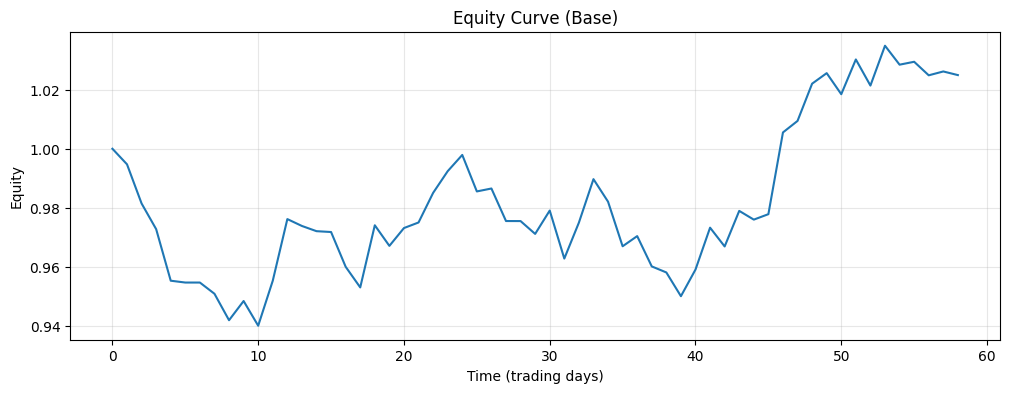

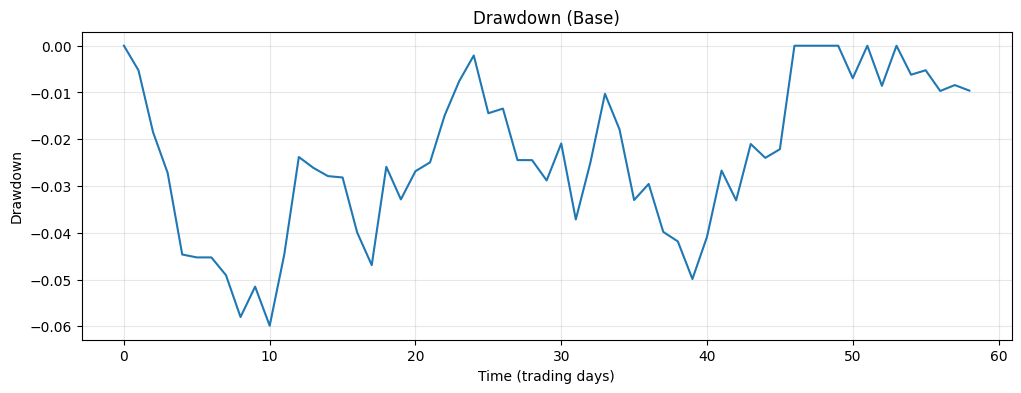

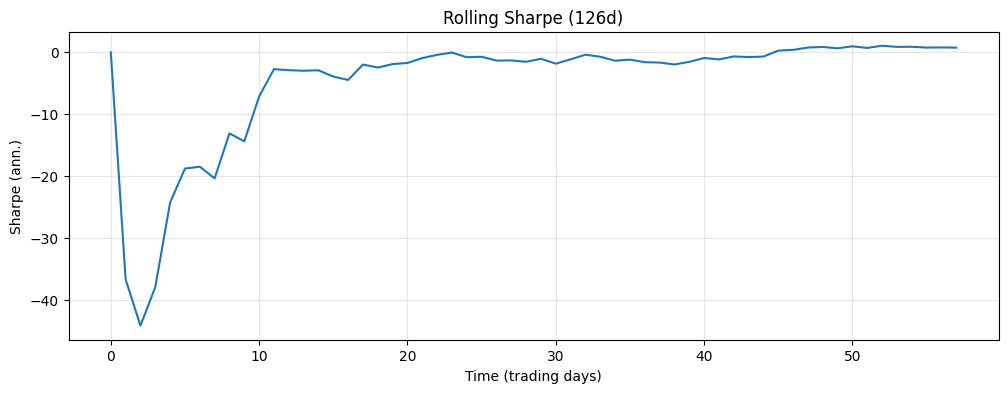

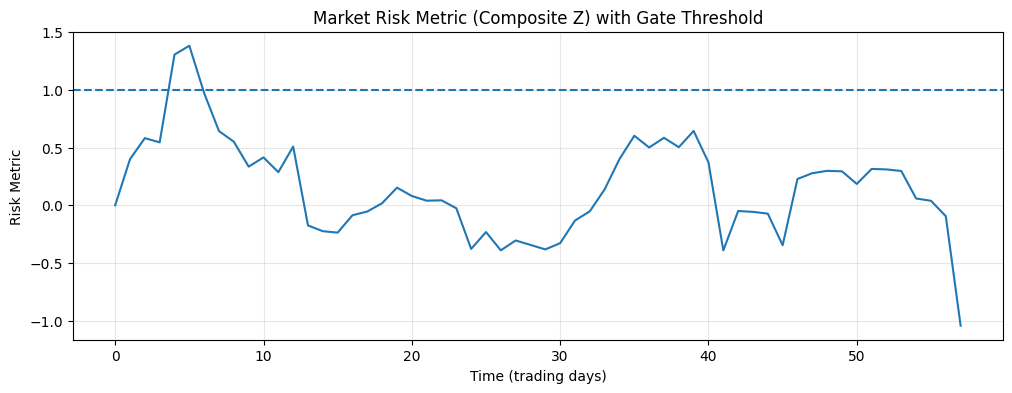

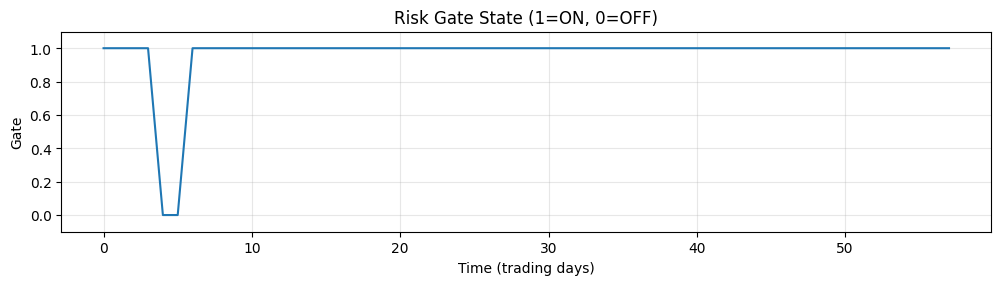

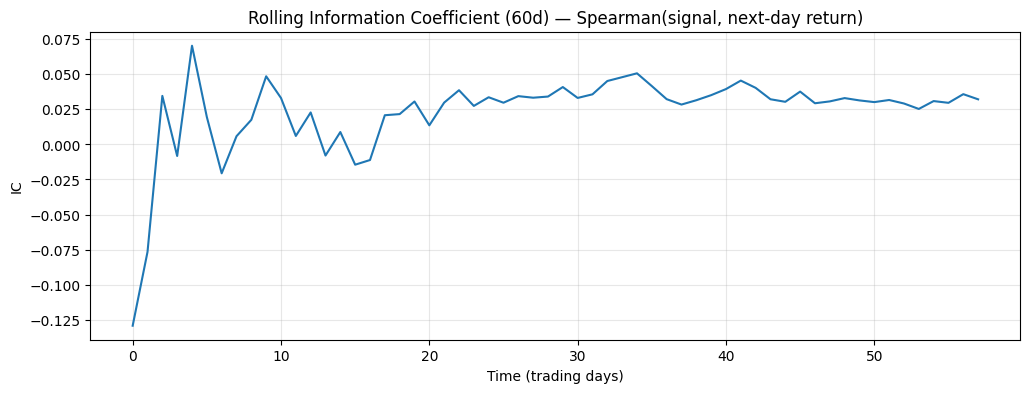

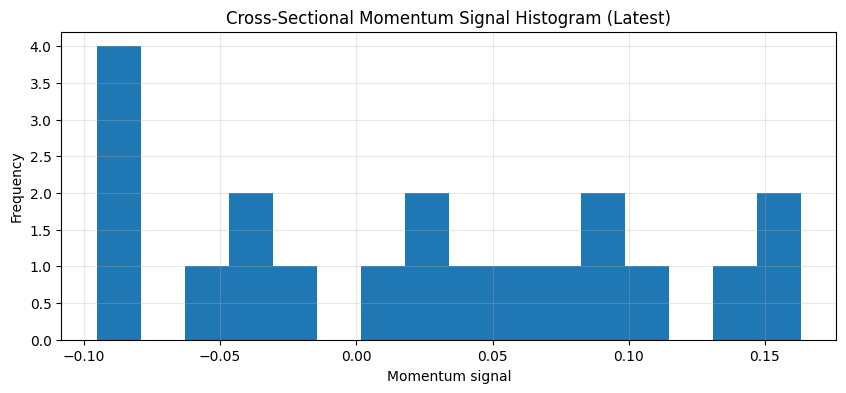

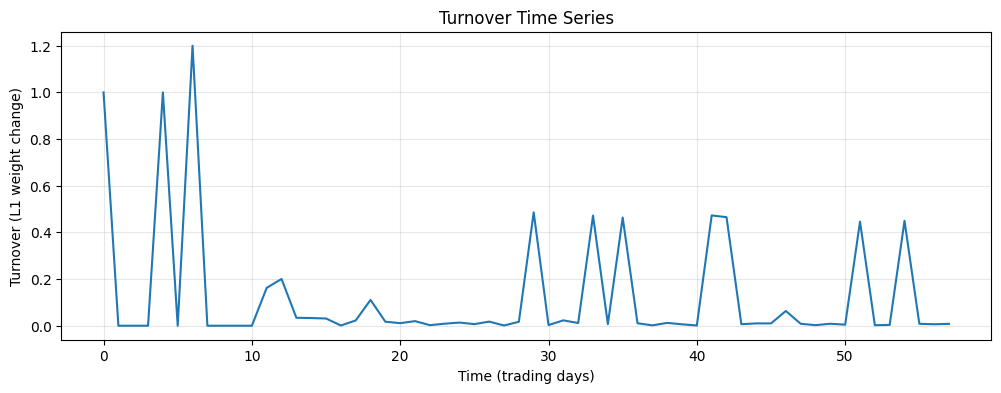

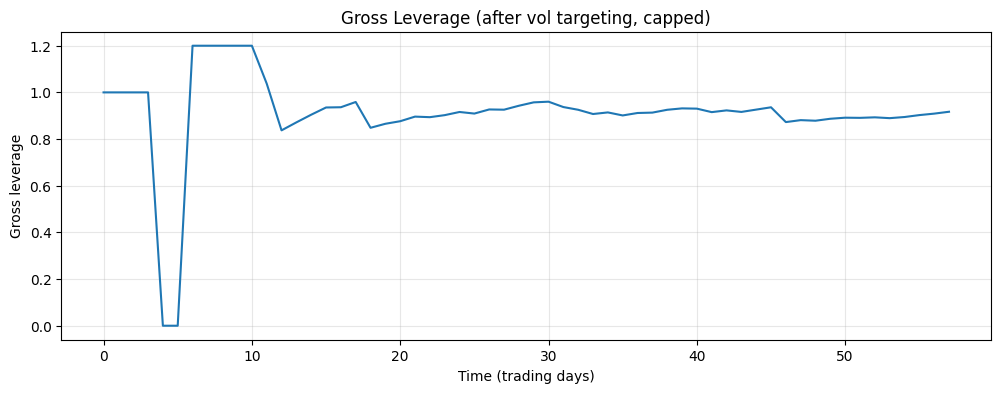

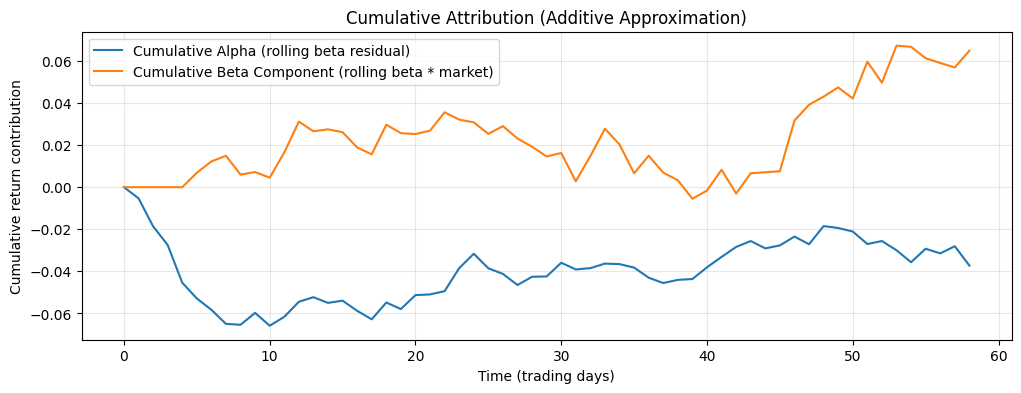

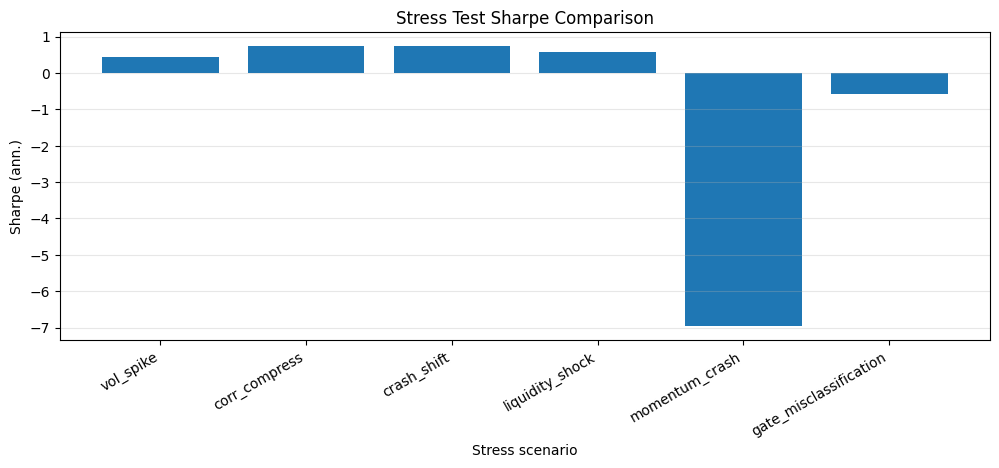

In [8]:
# CELL 9 — VISUALIZATION DASHBOARD (Matplotlib only; no narrative text)

# Recompute series for plotting from stored locals
eq = base_bt["equity"]
r = base_bt["returns"]
dd = compute_drawdowns(eq)
roll_sh = rolling_sharpe(r, 126)

# IC aligned to backtest horizon
ic_bt = ic_series[:len(r)]
roll_ic = []
w = 60
for i in range(len(ic_bt)):
    start = max(0, i - w + 1)
    roll_ic.append(statistics.mean(ic_bt[start:i+1]) if i >= 1 else ic_bt[0])

beta_252, alpha_252 = rolling_beta_alpha(r, [mkt_ret[t] for t in range(LB, LB + len(r))], 252)
beta_component = [beta_252[i] * mkt_ret[LB + i] for i in range(len(r))]
alpha_component = [r[i] - beta_component[i] for i in range(len(r))]
cum_beta = [0.0]
cum_alpha = [0.0]
for i in range(len(r)):
    cum_beta.append(cum_beta[-1] + beta_component[i])
    cum_alpha.append(cum_alpha[-1] + alpha_component[i])

turn = base_bt["turnover"]
gate = base_bt["gate"]
risk_metric = base_bt["risk_metric"]
gross_lev = base_bt["gross_leverage"]

# 1) Equity curve
plt.figure(figsize=(12,4))
plt.plot(eq)
plt.title("Equity Curve (Base)")
plt.xlabel("Time (trading days)")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.show()

# 2) Drawdown curve
plt.figure(figsize=(12,4))
plt.plot(dd)
plt.title("Drawdown (Base)")
plt.xlabel("Time (trading days)")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Rolling Sharpe (126d)
plt.figure(figsize=(12,4))
plt.plot(roll_sh)
plt.title("Rolling Sharpe (126d)")
plt.xlabel("Time (trading days)")
plt.ylabel("Sharpe (ann.)")
plt.grid(True, alpha=0.3)
plt.show()

# 4) Market Risk Metric (standardized composite)
plt.figure(figsize=(12,4))
plt.plot(risk_metric)
plt.axhline(CONFIG["risk_threshold"], linestyle="--")
plt.title("Market Risk Metric (Composite Z) with Gate Threshold")
plt.xlabel("Time (trading days)")
plt.ylabel("Risk Metric")
plt.grid(True, alpha=0.3)
plt.show()

# 5) Gate state (ON/OFF)
plt.figure(figsize=(12,2.6))
plt.plot(gate)
plt.ylim(-0.1, 1.1)
plt.title("Risk Gate State (1=ON, 0=OFF)")
plt.xlabel("Time (trading days)")
plt.ylabel("Gate")
plt.grid(True, alpha=0.3)
plt.show()

# 6) Rolling IC (60)
plt.figure(figsize=(12,4))
plt.plot(roll_ic)
plt.title("Rolling Information Coefficient (60d) — Spearman(signal, next-day return)")
plt.xlabel("Time (trading days)")
plt.ylabel("IC")
plt.grid(True, alpha=0.3)
plt.show()

# 7) Signal histogram (latest cross-section)
plt.figure(figsize=(10,4))
plt.hist(signals[len(r)-1], bins=16)
plt.title("Cross-Sectional Momentum Signal Histogram (Latest)")
plt.xlabel("Momentum signal")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# 8) Turnover series
plt.figure(figsize=(12,4))
plt.plot(turn)
plt.title("Turnover Time Series")
plt.xlabel("Time (trading days)")
plt.ylabel("Turnover (L1 weight change)")
plt.grid(True, alpha=0.3)
plt.show()

# 9) Gross leverage series
plt.figure(figsize=(12,4))
plt.plot(gross_lev)
plt.title("Gross Leverage (after vol targeting, capped)")
plt.xlabel("Time (trading days)")
plt.ylabel("Gross leverage")
plt.grid(True, alpha=0.3)
plt.show()

# 10) Alpha vs Beta cumulative attribution (additive approximation)
plt.figure(figsize=(12,4))
plt.plot(cum_alpha, label="Cumulative Alpha (rolling beta residual)")
plt.plot(cum_beta, label="Cumulative Beta Component (rolling beta * market)")
plt.title("Cumulative Attribution (Additive Approximation)")
plt.xlabel("Time (trading days)")
plt.ylabel("Cumulative return contribution")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 11) Stress Sharpe comparison (bar)
stress_sharpes = {k: stress_results[k]["sharpe"] for k in stress_results}
plt.figure(figsize=(12,4))
plt.bar(list(stress_sharpes.keys()), list(stress_sharpes.values()))
plt.title("Stress Test Sharpe Comparison")
plt.xlabel("Stress scenario")
plt.ylabel("Sharpe (ann.)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW

Cell 10

Cell 10 produces the maximum audit bundle and completes the research lifecycle. It includes parameter sensitivity, Monte Carlo robustness, and the tamper-evident integrity layer. The sensitivity grid is not presented as “optimization.” Its role is diagnostic: to test whether the strategy’s behavior is stable under reasonable hyperparameter variation. For Strategy 4, key hyperparameters include the momentum lookback, the risk threshold that controls gating, and the top selection fraction. If small changes in these parameters cause large swings in Sharpe or drawdown, the strategy is brittle. That brittleness is a governance signal, not a call to cherry-pick the best parameter.

Monte Carlo robustness builds a distributional envelope around outcomes. It perturbs residuals relative to a rolling beta structure, generating many plausible equity outcomes while preserving the systematic component. The point is to avoid single-path narratives. A strategy that looks good on one synthetic path may produce highly dispersed terminal outcomes under modest perturbations, indicating that its mechanism is sensitive to noise, execution path, or regime timing. The Monte Carlo summary records percentiles of terminal equity and stores sample paths for audit.

The integrity layer then hashes every artifact, produces an artifact hash registry, and computes a master bundle hash derived from the registry. This is the notebook’s tamper-evident seal. It allows a reviewer to verify that the zip bundle corresponds to a specific run and configuration, and that no deliverable has been modified post hoc. The cell also produces audit_index.json and creates lab_bundle.zip containing root files and deliverables. This packaging is not cosmetic; it is the minimum standard for defensible quantitative research in a regulated setting.

The learning objective of Cell 10 is to complete the transformation from a notebook into a governed laboratory. Strategy 4 is especially suited to this, because conditional deployment strategies often create subtle failure modes—gate error, re-entry churn, hidden beta exposure—that require systematic testing and traceable records. Cell 10 ensures the notebook’s outputs are not only informative but also auditable, reproducible, and review-ready.


###10.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 10 — MAXIMUM AUDIT BUNDLE (Sensitivity grid, Monte Carlo envelope, hashing, audit index, ZIP)

# -----------------------------
# Parameter Sensitivity Grid
# -----------------------------
sens = CONFIG["sensitivity"]
grid_results = []

base_params = {
    "momentum_lookback": CONFIG["momentum_lookback"],
    "risk_threshold": CONFIG["risk_threshold"],
    "top_fraction": CONFIG["top_fraction"]
}

# Deterministic grid search: vary 3 key hyperparameters; keep others fixed
for lb in sens["momentum_lookback"]:
    for rt in sens["risk_threshold"]:
        for tf in sens["top_fraction"]:
            # temporarily override global variables used by signal/backtest
            # regenerate signals deterministically for the new lookback
            old_LB = CONFIG["momentum_lookback"]
            old_RT = CONFIG["risk_threshold"]
            old_TF = CONFIG["top_fraction"]

            CONFIG["momentum_lookback"] = lb
            CONFIG["risk_threshold"] = rt
            CONFIG["top_fraction"] = tf

            # rebuild signals for this lookback
            LB_local = lb
            signals_local = []
            dispersion_local = []
            for t in range(LB_local, N-1):
                mom = []
                for i in range(M):
                    mom.append((prices[i][t] / prices[i][t - LB_local]) - 1.0)
                signals_local.append(mom)
                dispersion_local.append(safe_pstdev(mom))

            # swap globals used by run_backtest
            LB_saved = LB
            signals_saved = signals
            dispersion_saved = dispersion

            LB = LB_local
            signals = signals_local
            dispersion = dispersion_local

            bt = run_backtest()
            summ = summarize_bt(bt)

            grid_results.append({
                "momentum_lookback": lb,
                "risk_threshold": rt,
                "top_fraction": tf,
                "sharpe": summ["sharpe"],
                "max_drawdown": summ["max_drawdown"],
                "turnover_mean": summ["turnover_mean"],
                "terminal_equity": summ["terminal_equity"]
            })

            # restore globals
            LB = LB_saved
            signals = signals_saved
            dispersion = dispersion_saved

            CONFIG["momentum_lookback"] = old_LB
            CONFIG["risk_threshold"] = old_RT
            CONFIG["top_fraction"] = old_TF

# Persist sensitivity artifact
write_artifact(
    os.path.join(DELIVERABLES_DIR, "parameter_sensitivity.json"),
    analysis_dict={
        "grid_definition": sens,
        "notes": "Deterministic grid; re-generates momentum signals per lookback; re-runs full backtest each point."
    },
    outputs_dict={"grid_results": grid_results}
)

# -----------------------------
# Monte Carlo Robustness Envelope (≥200)
# -----------------------------
# Construct residual series relative to beta component as perturbation basis
port_r = base_bt["returns"]
mkt_r_aligned = [mkt_ret[t] for t in range(LB, LB + len(port_r))]
beta_252, _alpha_252 = rolling_beta_alpha(port_r, mkt_r_aligned, 252)
residuals = []
for i in range(len(port_r)):
    residuals.append(port_r[i] - beta_252[i] * mkt_r_aligned[i])

def simulate_equity_from_returns(returns_series):
    eq = 1.0
    for rr in returns_series:
        eq *= (1.0 + rr)
    return eq

mc_terminal = []
mc_paths_sample = []
R = CONFIG["monte_carlo_runs"]
noise_scale = CONFIG["monte_carlo_noise_scale"]

for k in range(R):
    sim_r = []
    for i in range(len(port_r)):
        # bootstrap residual + gaussian perturbation; keep market component fixed (structural)
        boot = residuals[random.randint(0, len(residuals)-1)]
        noise = np.random.normal(0.0, noise_scale * safe_pstdev(residuals))
        sim_r.append(beta_252[i] * mkt_r_aligned[i] + boot + noise)
    mc_terminal.append(simulate_equity_from_returns(sim_r))
    if k < 5:
        # store a few sample paths for audit (not plots, just data)
        eq_path = [1.0]
        for rr in sim_r[:500]:
            eq_path.append(eq_path[-1] * (1.0 + rr))
        mc_paths_sample.append(eq_path)

mc_terminal_arr = np.array(mc_terminal)
mc_summary = {
    "runs": R,
    "terminal_equity_mean": float(np.mean(mc_terminal_arr)),
    "terminal_equity_p05": float(np.percentile(mc_terminal_arr, 5)),
    "terminal_equity_p50": float(np.percentile(mc_terminal_arr, 50)),
    "terminal_equity_p95": float(np.percentile(mc_terminal_arr, 95)),
    "terminal_equity_min": float(np.min(mc_terminal_arr)),
    "terminal_equity_max": float(np.max(mc_terminal_arr))
}

write_artifact(
    os.path.join(DELIVERABLES_DIR, "monte_carlo_envelope.json"),
    analysis_dict={
        "method": "bootstrap residuals + gaussian perturbation around rolling beta structure",
        "noise_scale": noise_scale,
        "mc_summary": mc_summary
    },
    outputs_dict={"terminal_equity_distribution": mc_terminal[:50], "sample_paths_first5": mc_paths_sample}
)

# -----------------------------
# Consolidated governance outputs
# -----------------------------
write_artifact(
    os.path.join(DELIVERABLES_DIR, "governance_maturity.json"),
    analysis_dict={
        "maturity_level": "INSTITUTIONAL_RESEARCH_LAB",
        "stage_gates": {
            "gate_1_signal": "IC mean and dispersion non-degenerate",
            "gate_2_execution": "turnover p95 within tolerance (human-defined)",
            "gate_3_stress": "stress Sharpe does not collapse catastrophically",
            "gate_4_fragility": "fragility score thresholding → risk tier"
        },
        "notes": "Final gate decisions are advisory only; human approval required."
    },
    outputs_dict={}
)

# -----------------------------
# Audit Index + Hash Registry (tamper-evident)
# -----------------------------
# Collect all artifacts (root + deliverables)
artifact_paths = ["run_manifest.json", "prompts_log.jsonl", "risk_log.json"]
for fn in os.listdir(DELIVERABLES_DIR):
    artifact_paths.append(os.path.join(DELIVERABLES_DIR, fn))

artifact_hashes = {}
for p in artifact_paths:
    if os.path.isfile(p):
        artifact_hashes[p] = sha256_file(p)

# master bundle hash is hash of sorted (path|hash) lines
lines = [f"{k}|{artifact_hashes[k]}" for k in sorted(artifact_hashes.keys())]
master_bundle_hash = sha256_bytes("\n".join(lines).encode("utf-8"))

write_artifact(
    os.path.join(DELIVERABLES_DIR, "artifact_hash_registry.json"),
    analysis_dict={
        "hash_algorithm": "sha256",
        "master_bundle_hash": master_bundle_hash,
        "registry_definition": "sha256(file_bytes) per artifact path"
    },
    outputs_dict={"artifact_hashes": artifact_hashes}
)

audit_index = {
    "run_id": RUN_ID,
    "timestamp_utc": UTC_NOW,
    "config_hash": CONFIG_HASH,
    "master_bundle_hash": master_bundle_hash,
    "artifacts_count": len(artifact_hashes),
    "verification_status": "Not verified"
}
write_artifact(
    os.path.join(DELIVERABLES_DIR, "audit_index.json"),
    analysis_dict=audit_index,
    outputs_dict={}
)

# -----------------------------
# Final ZIP Bundle
# -----------------------------
zip_name = "lab_bundle.zip"
with zipfile.ZipFile(zip_name, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write("run_manifest.json")
    z.write("prompts_log.jsonl")
    z.write("risk_log.json")
    for fn in os.listdir(DELIVERABLES_DIR):
        z.write(os.path.join(DELIVERABLES_DIR, fn))

# Minimal final artifact status output (console)
print("RUN_ID:", RUN_ID)
print("CONFIG_HASH:", CONFIG_HASH)
print("MASTER_BUNDLE_HASH:", master_bundle_hash)
print("BUNDLE_WRITTEN:", zip_name)
print("DELIVERABLES_COUNT:", len(os.listdir(DELIVERABLES_DIR)))


[Cell5][  1.14%] step    1/  88 | gate=1 rm=+0.000 disp=0.0527 | equity=1.0078 dd=+0.000 | turnover=1.000 grossLev=1.000 | elapsed=52.2s eta=nans
[Cell5][ 57.95%] step   51/  88 | gate=1 rm=+0.338 disp=0.0563 | equity=0.9284 dd=-0.079 | turnover=0.005 grossLev=0.921 | elapsed=53.7s eta=39.8s
[Cell5][100.00%] step   88/  88 | gate=1 rm=-2.157 disp=0.0626 | equity=0.9897 dd=-0.018 | turnover=0.000 grossLev=0.988 | elapsed=55.3s eta=0.0s
[Cell5][  1.14%] step    1/  88 | gate=1 rm=+0.000 disp=0.0527 | equity=1.0078 dd=+0.000 | turnover=1.000 grossLev=1.000 | elapsed=55.4s eta=nans
[Cell5][ 57.95%] step   51/  88 | gate=1 rm=+0.338 disp=0.0563 | equity=0.9284 dd=-0.079 | turnover=0.005 grossLev=0.921 | elapsed=56.9s eta=42.1s
[Cell5][100.00%] step   88/  88 | gate=1 rm=-2.157 disp=0.0626 | equity=0.9897 dd=-0.018 | turnover=0.000 grossLev=0.988 | elapsed=58.5s eta=0.0s
[Cell5][  1.14%] step    1/  88 | gate=1 rm=+0.000 disp=0.0527 | equity=1.0078 dd=+0.000 | turnover=1.000 grossLev=1.000 |

##11.CONCLUSION


**Conclusion — Strategy 4: Momentum + Market Risk Gate**

This laboratory is best understood as a lesson in conditional feasibility. Momentum as a standalone rule—rank winners, buy them, rebalance—can appear compelling in a world where volatility is a nuisance and execution is free. In the world that institutions inhabit, momentum is instead a policy that lives at the boundary between gradual repricing and constraint-driven liquidation. The notebook demonstrates that the strategy’s success or failure is not primarily a question of whether momentum “exists.” It is a question of whether the market’s risk geometry allows momentum exposure to be held without being overwhelmed by correlation compression, volatility expansion, and liquidity-steepened impact costs. The Market Risk Gate is the operationalization of that insight: it turns regime awareness into an explicit mechanism rather than an implicit hope.

The first structural learning is that **regimes are not labels; they are constraint sets**. In the synthetic market constructed here, calm and trend regimes are characterized by moderate correlations and manageable volatility. In those states, cross-sectional dispersion is typically sufficient for ranking to be meaningful, turnover can be controlled, and the execution surface is relatively shallow. In choppy and crisis regimes, correlations rise and volatility expands. This is not merely “more risk”; it is a change in geometry. Diversification weakens, the effective dimensionality of returns collapses, and the portfolio becomes more exposed to the common factor. In that geometry, the momentum signal can become noisy and crowded at the same time: noisy because rank separation shrinks, crowded because many strategies hold similar winners. The gate’s job is not to predict crisis; it is to recognize the geometry in which holding a momentum sleeve becomes structurally unsafe.

A second learning concerns **dispersion dependence**. Cross-sectional momentum requires that the signal vector contains meaningful cross-sectional structure. If dispersion collapses, the ranking is unstable: minor noise can flip membership in the top set, which increases turnover. The notebook’s dispersion threshold is therefore not a performance tweak; it is a feasibility control. It protects the strategy from trading when it lacks a sufficient signal-to-noise ratio at the cross-sectional level. This is an institutional mindset: the goal is not to force activity every day, but to avoid paying the execution surface when the signal cannot justify the transition.

A third learning is that **execution is a state variable**. Costs are not static bps deducted after the fact. In this notebook, costs rise with turnover and rise nonlinearly via quadratic impact. They also rise with a liquidity stress multiplier that worsens in crisis regimes. This is a key mechanism-first point: the marginal cost of changing inventory is steepest precisely when the agent most wants to change inventory. In practice, this creates path dependence. A strategy that rebalances aggressively in calm regimes may survive; the same strategy, forced to rebalance in stress regimes, may see its returns consumed by impact. The notebook makes this visible by recording turnover, gross leverage, and execution audit artifacts alongside performance metrics.

The stress suite reinforces these lessons by attacking the strategy’s hypothesis directly. Generic stresses—volatility spikes, correlation compression, crash shifts, and liquidity shocks—test whether the policy’s performance is an artifact of a single regime configuration. Strategy-specific stresses—momentum crash and gate misclassification—test the strategy’s core vulnerability: whether it fails when winners reverse, and whether it fails when the gate is wrong. This is not a theoretical exercise. Gate misclassification is one of the most plausible real-world failure modes because the gate is built from estimated quantities: volatility, correlation, drawdown. Estimation error or delayed detection can produce false ON states exactly when risk is rising. Conversely, overly conservative gating can produce false OFF states that forfeit legitimate opportunities and may increase turnover when re-entry occurs. The notebook’s stress tests make these failure channels explicit and measurable.

Fragility analysis synthesizes the stress results into a governance object: a fragility score built from Sharpe degradation and drawdown amplification. The point is not to produce a single number that declares “good” or “bad.” The point is to create a disciplined summary of how the strategy degrades under adverse but structurally motivated perturbations. In institutional research, the central question is: **how does this strategy fail, and are the controls proportionate to the failure modes?** The notebook’s risk tiering and deployment classification are conservative by construction. They are designed to keep the reader anchored in governance reality: synthetic results are not verified; external validation is absent; and therefore any deployment classification must be cautious and control-driven rather than optimistic.

The parameter sensitivity grid and Monte Carlo envelope further strengthen that discipline. Sensitivity analysis answers a narrow but critical question: do small changes in lookback, threshold, or selection fraction produce large changes in outcomes? If so, the strategy is brittle and may be overfit to the synthetic environment’s specific structure. Monte Carlo robustness provides a distributional view: rather than treating one equity curve as “the” outcome, it treats it as one draw from a family of plausible paths under residual perturbations. The goal is to develop an instinct for robustness: a strategy whose outcomes are highly dispersed under modest perturbations deserves a higher model-risk classification and stricter deployment gating.

What should the reader do next? The correct next step is not to optimize. It is to iterate structurally. First, treat the gate definition as a hypothesis about feasibility and test alternative formulations: change the weights on volatility versus correlation, change the lookback windows, and observe not just the Sharpe but the **gate behavior**—how often it turns off, how it interacts with drawdown stops, and how it affects turnover. Second, study momentum crash fragility more deeply by varying the magnitude and frequency of reversals, and by shifting them to coincide with correlation compression. Third, study execution realism: increase the quadratic impact coefficient, and observe whether the strategy’s edge survives. If a strategy’s viability depends on unrealistically shallow impact, it is not a strategy; it is a frictionless artifact.

The final lesson is conceptual. Mechanism-first thinking rejects the idea that a strategy is “a formula that prints money.” A strategy is a policy that interacts with a market mechanism, pays costs to change state, and survives under constraints. In the momentum context, the market mechanism includes behavioral under-reaction and slow capital during calm regimes, and constraint-driven liquidation and correlation compression during stress. The Market Risk Gate is a minimal attempt to respect that mechanism. It does not eliminate fragility; it makes fragility visible, controllable, and discussable. That is the educational value of this laboratory.

This notebook is therefore a training ground for professional intuition. It teaches that signal quality is not enough; feasibility matters. It teaches that risk geometry changes, and that strategies can fail when they ignore that change. It teaches that execution costs are not an afterthought but a surface that prices transitions in inventory. And it teaches governance discipline: record artifacts, stress the hypothesis, quantify fragility, and keep outputs labeled “Not verified” until human review and external validation are performed. In an institutional setting, that discipline is what separates research from superstition.
